In [ ]:
# !pip install torch
# !pip3 install Cython
# !pip3 install sympy

In [ ]:
import os
os.getcwd()
if os.getcwd() != '/content/drive/MyDrive/Projects/RBCs_Borealis_AIs_Shelter_Occupancy_Forecast':
  os.chdir('drive/MyDrive/Projects/RBCs_Borealis_AIs_Shelter_Occupancy_Forecast')
os.getcwd()

import pandas as pd
import torch
import plotting as pl
import dataload as dl

DATASET_DIR = 'Datasets'

In [ ]:
data_21 = r'{}/daily-shelter-overnight-service-occupancy-capacity-2021.csv'.format(DATASET_DIR)
data_22 = r'{}/daily-shelter-overnight-service-occupancy-capacity-2022.csv'.format(DATASET_DIR)
data_23 = r'{}/daily-shelter-overnight-service-occupancy-capacity-2023.csv'.format(DATASET_DIR)

# data_24 = r"C:\Users\tomng\Desktop\RBC's Borealis AI Lets Solve It\Datasets\Daily shelter overnight occupancy.csv"
# links = [data_24, data_23, data_22, data_21]
links = [data_23, data_22, data_21]

#Weather Data
data_w_21 = r'{}/en_climate_daily_ON_6158355_2021_P1D.csv'.format(DATASET_DIR)
data_w_22 = r'{}/en_climate_daily_ON_6158355_2022_P1D.csv'.format(DATASET_DIR)
data_w_23 = r'{}/en_climate_daily_ON_6158355_2023_P1D.csv'.format(DATASET_DIR)

links_weather = [data_w_23, data_w_22, data_w_21]

#Housing
data_housing = r'{}/Housing.csv'.format(DATASET_DIR)

#Crisis helpline
data_crisis = r'{}/Persons_in_Crisis_Calls_for_Service_Attended_Open_Data.csv'.format(DATASET_DIR)

print(links_weather)

['Datasets/en_climate_daily_ON_6158355_2023_P1D.csv', 'Datasets/en_climate_daily_ON_6158355_2022_P1D.csv', 'Datasets/en_climate_daily_ON_6158355_2021_P1D.csv']


In [ ]:
#Load Data takes in all the datasets and create a general dataframe to be adapted again for training different types of Model
dataframe, iso_data = dl.loadData(links, links_weather, data_housing, data_crisis)
#Function output explanation:
#	--DataFrame-- is the general combined data of all datasets, unaltered.
#	--iso_data-- is the dataframe but broken up into a hashmap where the key is the shelter id and the value is the data for that specific shelter

print(dataframe)

#
df = dl.prep_Data(dataframe)
df = df[['OCCUPANCY_DATE', 'OCCUPIED_PERCENTAGE']]

Reading csv from  Datasets/daily-shelter-overnight-service-occupancy-capacity-2023.csv
Number of rows in the data_23Frame: Datasets/daily-shelter-overnight-service-occupancy-capacity-2023.csv 48345
Reading csv from  Datasets/daily-shelter-overnight-service-occupancy-capacity-2022.csv
Number of rows in the data_23Frame: Datasets/daily-shelter-overnight-service-occupancy-capacity-2022.csv 49478
Reading csv from  Datasets/daily-shelter-overnight-service-occupancy-capacity-2021.csv
Number of rows in the data_23Frame: Datasets/daily-shelter-overnight-service-occupancy-capacity-2021.csv 50944
Reading csv from  Datasets/en_climate_daily_ON_6158355_2023_P1D.csv
Number of rows in the data_23Frame: Datasets/en_climate_daily_ON_6158355_2023_P1D.csv 365
Reading csv from  Datasets/en_climate_daily_ON_6158355_2022_P1D.csv
Number of rows in the data_23Frame: Datasets/en_climate_daily_ON_6158355_2022_P1D.csv 365
Reading csv from  Datasets/en_climate_daily_ON_6158355_2021_P1D.csv
Number of rows in the 

In [ ]:
df = dl.prep_Data(dataframe)
print(df)

uni_headers = ['PROGRAM_ID', 'OCCUPANCY_DATE', 'OCCUPIED_PERCENTAGE']
df_univariate = df[uni_headers]
df_univariate['OCCUPANCY_DATE'] = (pd.to_datetime(df_univariate['OCCUPANCY_DATE'])).apply(lambda x: int(x.strftime("%Y%m%d")))
# df_univariate['OCCUPANCY_DATE'] = df_univariate['OCCUPANCY_DATE'].astype(int) // 10**9  # Convert to Unix timestamp

multi_headers = ['PROGRAM_ID', 'OCCUPANCY_DATE', 'OCCUPIED_PERCENTAGE']
df_multivariate = df[multi_headers]
# df_multivariate['OCCUPANCY_DATE'] = pd.to_datetime(df_multivariate['OCCUPANCY_DATE'])
# df_multivariate['OCCUPANCY_DATE'] = df_multivariate['OCCUPANCY_DATE'].astype(int) // 10**9  # Convert to Unix timestamp

       OCCUPANCY_DATE  PROGRAM_ID  Max Temp (Â°C)  Min Temp (Â°C)  \
0          2021-01-01       15371             2.5            -1.0   
1          2021-01-01       14611             2.5            -1.0   
2          2021-01-01       15071             2.5            -1.0   
3          2021-01-01       12111             2.5            -1.0   
4          2021-01-01       12211             2.5            -1.0   
...               ...         ...             ...             ...   
148762     2023-12-31       17991             1.6            -1.0   
148763     2023-12-31       15331             1.6            -1.0   
148764     2023-12-31       16091             1.6            -1.0   
148765     2023-12-31       11951             1.6            -1.0   
148766     2023-12-31       17091             1.6            -1.0   

        Mean Temp (Â°C)  Heat Deg Days (Â°C)  Cool Deg Days (Â°C)  \
0                   0.7                 17.3                  0.0   
1                   0.7          

<ipython-input-5-ce067e3acff1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_univariate['OCCUPANCY_DATE'] = (pd.to_datetime(df_univariate['OCCUPANCY_DATE'])).apply(lambda x: int(x.strftime("%Y%m%d")))


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


# Define your AutoRegressive model
class AutoRegressiveModel(nn.Module):
    def __init__(self, input_size, target_size):
        super().__init__()
        self.linear = nn.Linear(input_size, target_size)

    def forward(self, x):
        predictions = self.linear(x)
        return predictions

class BaseAutoRegressionModel:
  def __init__(self, df, x_headers, y_headers, num_epochs, lr, sequence_input_length, sequence_output_length):
    self.df = df
    self.x_headers = x_headers
    self.y_headers = y_headers
    # self.X, self.y = self.df[x_headers], self.df[y_headers]
    # self.X_with_date = self.df[x_headers+['OCCUPANCY_DATE']]
    self.num_epochs = num_epochs
    # self.model = None
    self.graph_id = 'All'
    self.lr = lr
    self.sequence_input_length = sequence_input_length
    self.sequence_output_length = sequence_output_length

  def convert_to_sequence(self, data, seq_length):
    data = data.astype(float)
    # Convert the column to the desired format
    result = [data[i:i+seq_length].values.tolist() for i in range(len(data) - seq_length + 1)]

    # Create a DataFrame from the resulting list of lists
    result_df = pd.DataFrame(result)

    return result_df

  def shift_by_n(self, X, y, n):
    # print(X[:-n], y[n:])
    return X[:-n], y[n:]

  def run_model(self, X, y, graph_id, plotting_occupancy = True, turn_off_print = False):
    assert len(X) == len(y)
    print("Starting training")
    # num_samples = 1000
    # sequence_length = 10

    print("--------- DATA SPLITTING ---------")
    # Split the data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    print("--------- CONVERTAIN DATA TO TENSORS ---------")
    # Convert DataFrame to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    print("--------- CREATE DATALOADERS ---------")
    # Create DataLoader for training, validation, and test sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print("--------- RETRIEVING INPUT SIZE AND TARGET SIZE ---------")
    input_size = X_train_tensor.size(1)
    target_size = y_train_tensor.size(1)
    print("Input size: {}, target size: {}".format(input_size, target_size))

    print("--------- INSTANTIATE AUTOREGRESSIVE MODEL ---------")
    # Instantiate the AutoRegressive model
    model = AutoRegressiveModel(input_size=input_size, target_size=target_size)

    print("--------- INSTANTIATE OPTIMIZER AND CRITERION ---------")
    print('Model params: {}'.format(model.parameters()))
    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
    criterion = nn.MSELoss()

    print("--------- TRANING AND VALIDATION ---------")

    for epoch in range(self.num_epochs):
        # Training
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss = criterion(outputs, targets)
                val_losses.append(val_loss.item())
        avg_val_loss = sum(val_losses) / len(val_losses)
        print(f"Epoch {epoch+1}/{self.num_epochs}, Validation Loss: {avg_val_loss:.4f}") if not turn_off_print else None

    # Testing
    model.eval()
    test_losses = []
    date = []
    real = []
    predicted = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss = criterion(outputs, targets)
            test_losses.append(test_loss.item())

            # Convert tensors to numpy arrays and flatten them
            inputs_np = (inputs.squeeze() * 10**9 ).numpy().tolist()
            targets_np = targets.squeeze().numpy().tolist()
            outputs_np = outputs.squeeze().numpy().tolist()

            # Extend lists with data from the current batch
            date.extend(inputs_np)
            real.extend(targets_np)
            predicted.extend(outputs_np)

    avg_test_loss = sum(test_losses) / len(test_losses)
    print(f"Test Loss: {avg_test_loss:.4f}")

    return model, real, predicted, loss, val_loss, test_loss,

  def plot_results_against_all_shelters(self):

    # Group by 'DATE' and calculate the average of 'OCCUPANCY' for each group
    combined_df = self.df.groupby('OCCUPANCY_DATE')['OCCUPIED_PERCENTAGE'].mean().reset_index()

    print(combined_df)
    X = combined_df[self.x_headers]
    y = combined_df[self.y_headers]
    X, y = self.shift_by_n(X, y, 1)

    output = self.run_model(X, y, 'all', True, True)
    model = output[0]

    return model

  def test_combined_model(self, num_future_preds, num_shelters_plot = 0, plotting_occupancy = True, turn_off_print = False, specified_shelters = None):

      model = self.plot_results_against_all_shelters()

      if specified_shelters:
        shelters = specified_shelters
      else:
        shelters = self.unique_shelters[:num_shelters_plot+1]

      if plotting_occupancy:
        print("--------- Plotting predictions vs target ---------")

        for i in shelters:
          graph_id = i
          tmp_df = self.df[self.df['PROGRAM_ID'] == graph_id]
          X = tmp_df[self.x_headers]
          y = tmp_df[self.y_headers]
          X, y = self.shift_by_n(X, y, 1)

          # Convert DataFrame to PyTorch tensors
          X_tensor = torch.tensor(X.values, dtype=torch.float32)
          y_tensor = torch.tensor(y.values, dtype=torch.float32)

          # Create DataLoader for the entire dataset
          dataset = TensorDataset(X_tensor, y_tensor)

          loader = DataLoader(dataset, batch_size=32, shuffle=False)

          predictions = []
          with torch.no_grad():
            for inputs, targets in loader:
              outputs = model(inputs)
              predictions.extend(outputs.numpy().tolist())

            for i in range(num_future_preds):
              inputs = torch.tensor([predictions[-32:-1]], dtype=torch.float32) # make predictions based on the last prediction
              # X_tensor = torch.tensor(predictions[-1], dtype=torch.float32)
              outputs = model(inputs)
              outputs = torch.tensor([[outputs[-1][-1]]], dtype=torch.float32)
              predictions.extend(outputs.numpy().tolist())

          self.plot_general(y.values, predictions, graph_id)

  # def run_model_on_each_shelter(self, num_shelters_plot, plotting_occupancy = True, turn_off_print = False, specified_shelters = None):
  #   self.unique_shelters = self.df['PROGRAM_ID'].unique() # retrieves all shelters

  #   print("Num unique shelters: {}".format(len(self.unique_shelters)))
  #   if specified_shelters:
  #     shelters = specified_shelters
  #   else:
  #     shelters = self.unique_shelters[:num_shelters_plot+1]

  #   for i in shelters:
  #     graph_id = i
  #     tmp_df = self.df[self.df['PROGRAM_ID'] == graph_id]
  #     print(tmp_df)
  #     # self.X, self.y = tmp_df[self.x_headers], tmp_df[self.y_headers]
  #     # self.X = self.convert_to_sequence(self.X, self.sequence_input_length)
  #     # self.y = self.convert_to_sequence(self.y, self.sequence_output_length)
  #     X = tmp_df[self.x_headers]
  #     y = tmp_df[self.y_headers]

  #     output = self.run_model(X, y, graph_id, plotting_occupancy, turn_off_print)
  #     model = output[0]

  #     if plotting_occupancy:

  #       print("--------- Plotting predictions vs target ---------")

  #       # Convert DataFrame to PyTorch tensors
  #       X_tensor = torch.tensor(X.values, dtype=torch.float32)
  #       y_tensor = torch.tensor(y.values, dtype=torch.float32)

  #       # Create DataLoader for the entire dataset
  #       dataset = TensorDataset(X_tensor, y_tensor)

  #       loader = DataLoader(dataset, batch_size=32, shuffle=False)
  #       predictions = []
  #       print("this is prediction", predictions)
  #       with torch.no_grad():
  #         for inputs, targets in loader:
  #           outputs = model(inputs)
  #           predictions.extend(outputs.numpy().tolist())

  #       self.plot_general(y.values, predictions, graph_id)


  #Inferring Data for All Shelters
  def plot_general(self, real, predicted, id):

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(real, label='Target', marker='o')
    plt.plot(predicted, label='Predictions', marker='x')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title('Predictions vs Target for Shelter {}'.format(id))
    plt.legend()
    plt.show()




      OCCUPANCY_DATE  OCCUPIED_PERCENTAGE
0           20210101            94.204801
1           20210102            94.383922
2           20210103            94.042473
3           20210104            94.063670
4           20210105            93.901983
...              ...                  ...
1090        20231227            99.226770
1091        20231228            99.228313
1092        20231229            99.203293
1093        20231230            99.176299
1094        20231231            97.725796

[1095 rows x 2 columns]
Starting training
--------- DATA SPLITTING ---------
--------- CONVERTAIN DATA TO TENSORS ---------
--------- CREATE DATALOADERS ---------
--------- RETRIEVING INPUT SIZE AND TARGET SIZE ---------
Input size: 1, target size: 1
--------- INSTANTIATE AUTOREGRESSIVE MODEL ---------
--------- INSTANTIATE OPTIMIZER AND CRITERION ---------
Model params: <generator object Module.parameters at 0x7dc41d8c6a40>
--------- TRANING AND VALIDATION ---------
Test Loss: 0.0715
-----

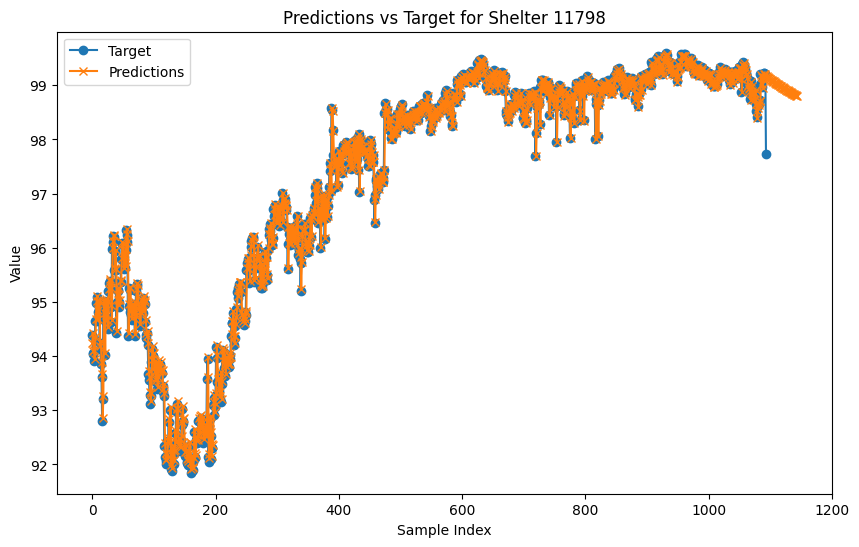

this is outputs tensor([[99.2116]])
this is outputs tensor([[99.2107]])
this is outputs tensor([[99.1942]])
this is outputs tensor([[99.1933]])
this is outputs tensor([[99.1770]])
this is outputs tensor([[99.1761]])
this is outputs tensor([[99.1600]])
this is outputs tensor([[99.1591]])
this is outputs tensor([[99.1432]])
this is outputs tensor([[99.1423]])
this is outputs tensor([[99.1266]])
this is outputs tensor([[99.1257]])
this is outputs tensor([[99.1102]])
this is outputs tensor([[99.1094]])
this is outputs tensor([[99.0940]])
this is outputs tensor([[99.0932]])
this is outputs tensor([[99.0780]])
this is outputs tensor([[99.0771]])
this is outputs tensor([[99.0622]])
this is outputs tensor([[99.0613]])
this is outputs tensor([[99.0465]])
this is outputs tensor([[99.0457]])
this is outputs tensor([[99.0311]])
this is outputs tensor([[99.0303]])
this is outputs tensor([[99.0158]])
this is outputs tensor([[99.0150]])
this is outputs tensor([[99.0007]])
this is outputs tensor([[98.

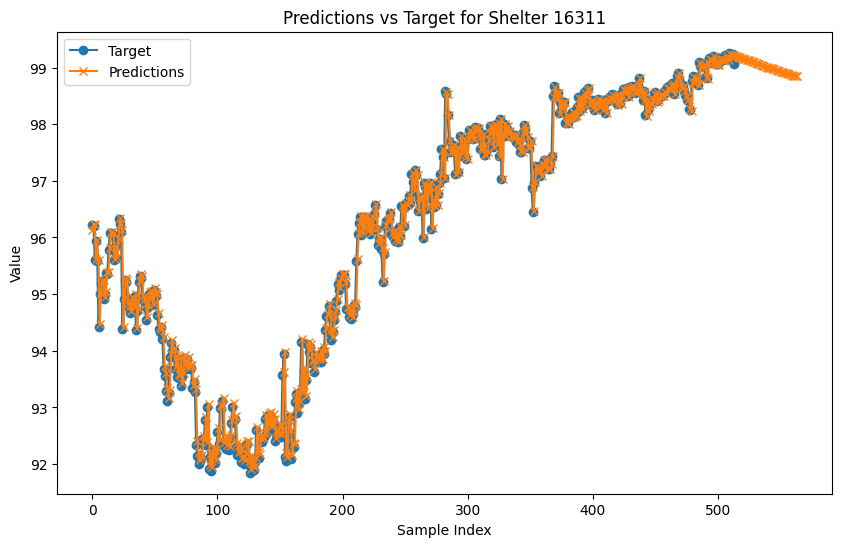

this is outputs tensor([[99.0489]])
this is outputs tensor([[99.1365]])
this is outputs tensor([[99.0334]])
this is outputs tensor([[99.1200]])
this is outputs tensor([[99.0181]])
this is outputs tensor([[99.1037]])
this is outputs tensor([[99.0030]])
this is outputs tensor([[99.0875]])
this is outputs tensor([[98.9880]])
this is outputs tensor([[99.0716]])
this is outputs tensor([[98.9733]])
this is outputs tensor([[99.0558]])
this is outputs tensor([[98.9587]])
this is outputs tensor([[99.0403]])
this is outputs tensor([[98.9443]])
this is outputs tensor([[99.0249]])
this is outputs tensor([[98.9300]])
this is outputs tensor([[99.0097]])
this is outputs tensor([[98.9160]])
this is outputs tensor([[98.9947]])
this is outputs tensor([[98.9021]])
this is outputs tensor([[98.9799]])
this is outputs tensor([[98.8883]])
this is outputs tensor([[98.9652]])
this is outputs tensor([[98.8747]])
this is outputs tensor([[98.9507]])
this is outputs tensor([[98.8613]])
this is outputs tensor([[98.

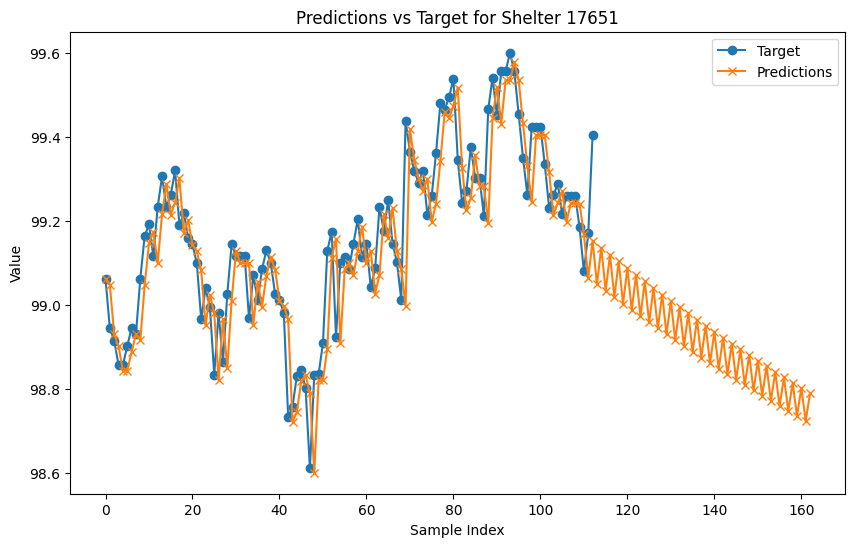

this is outputs tensor([[99.1689]])
this is outputs tensor([[99.1425]])
this is outputs tensor([[99.1520]])
this is outputs tensor([[99.1259]])
this is outputs tensor([[99.1353]])
this is outputs tensor([[99.1095]])
this is outputs tensor([[99.1188]])
this is outputs tensor([[99.0933]])
this is outputs tensor([[99.1025]])
this is outputs tensor([[99.0773]])
this is outputs tensor([[99.0863]])
this is outputs tensor([[99.0615]])
this is outputs tensor([[99.0704]])
this is outputs tensor([[99.0459]])
this is outputs tensor([[99.0547]])
this is outputs tensor([[99.0304]])
this is outputs tensor([[99.0391]])
this is outputs tensor([[99.0152]])
this is outputs tensor([[99.0238]])
this is outputs tensor([[99.0001]])
this is outputs tensor([[99.0086]])
this is outputs tensor([[98.9852]])
this is outputs tensor([[98.9936]])
this is outputs tensor([[98.9705]])
this is outputs tensor([[98.9788]])
this is outputs tensor([[98.9559]])
this is outputs tensor([[98.9641]])
this is outputs tensor([[98.

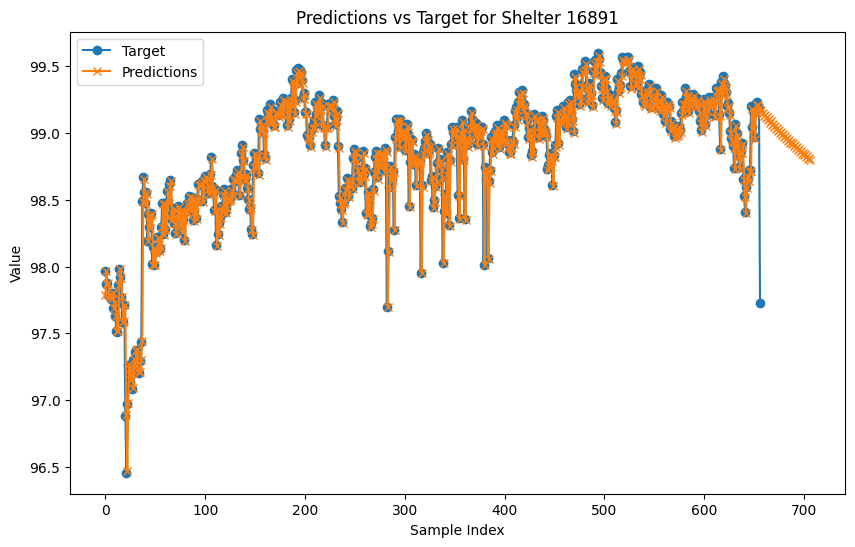

In [ ]:
uni_model = BaseAutoRegressionModel(df_univariate, ['OCCUPIED_PERCENTAGE'], ['OCCUPIED_PERCENTAGE'], 100, 0.01, 5, 5)
uni_model.test_combined_model(50, num_shelters_plot = 0, plotting_occupancy = True, turn_off_print = False, specified_shelters = [11798, 16311, 17651, 16891])
# uni_model.run_model_on_each_shelter(10, True, True, specified_shelters = [11798, 16311, 17651, 16891])

# multi_model = BaseAutoRegressionModel(df_multivariate, ['OCCUPANCY_DATE', 'Overdose', 'Person in Crisis', 'Suicide-related'], ['OCCUPIED_PERCENTAGE'], 300)
# multi_model.run_model()

In [ ]:
pl.plot_general(X_train, y_train, n_steps, scaler, model, date_frame)